# Mango Classification exploration

In [61]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [62]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [63]:
torch.cuda.set_device (0)

In [64]:
torch.cuda.is_available()

True

In [65]:
PATH = "data/mango/"
sz = 224
arch = resnext101_64
bs = 58

First look at mango pictures

In [48]:
os.listdir(PATH)

['.ipynb_checkpoints', 'valid', 'models', 'train', 'tmp']

In [37]:
os.listdir(f'{PATH}valid')

['.ipynb_checkpoints', 'qual1', 'qual2']

In [38]:
files = os.listdir(f'{PATH}valid/qual1')[:5]
files

['mango_2017-09-13 15:46:50.333531.jpg',
 'mango_2017-09-13 15:44:37.769756.jpg',
 'mango_2017-09-13 15:44:20.615767.jpg',
 'mango_2017-09-13 15:45:50.786879.jpg',
 'mango_2017-09-13 15:42:43.322206.jpg']

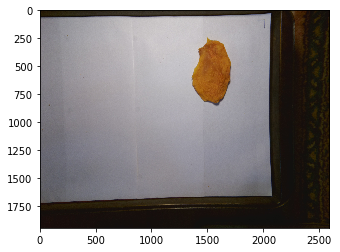

In [10]:
img = plt.imread(f'{PATH}valid/qual1/{files[4]}')
plt.imshow(img);

Here's the raw data shape

In [10]:
img.shape

(1944, 2592, 3)

In [43]:
img[:4,:4]

array([[[35, 22,  6],
        [37, 24,  8],
        [39, 26, 10],
        [34, 21,  5]],

       [[30, 23,  5],
        [33, 24,  7],
        [36, 24,  8],
        [35, 22,  6]],

       [[25, 22,  5],
        [30, 24,  8],
        [33, 24,  7],
        [33, 21,  5]],

       [[29, 26,  9],
        [35, 29, 13],
        [31, 24,  8],
        [34, 25,  8]]], dtype=uint8)


### Our first model: quick start
We're going to use a pre-trained model, that is, a model created by some one else to solve a different problem. Instead of building a model from scratch to solve a similar problem, we'll use a model trained on ImageNet (1.2 million images and 1000 classes) as a starting point. The model is a Convolutional Neural Network (CNN), a type of Neural Network that builds state-of-the-art models for computer vision. 

We will be using the resnet34 model. resnet34 is a version of the model that won the 2015 ImageNet competition. Here is more info on resnet models. 
https://github.com/KaimingHe/deep-residual-networks

In [44]:
# Uncomment the below if you need to reset your precomputed activations
# shutil.rmtree(f'{PATH}tmp', ignore_errors=True)

In [45]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms_from_model(arch, sz))
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 3)

epoch      trn_loss   val_loss   accuracy                
    0      0.782597   0.478647   0.851852  
    1      0.588838   0.269332   0.962963        
    2      0.428858   0.155495   0.962963        



[array([0.1555]), 0.9629629850387573]

### Analyzing results: looking at pictures
As well as looking at the overall metrics, it's also a good idea to look at examples of each of:

A few correct labels at random
A few incorrect labels at random
The most correct labels of each class (i.e. those with highest probability that are correct)
The most incorrect labels of each class (i.e. those with highest probability that are incorrect)
The most uncertain labels (i.e. those with probability closest to 0.5).

In [19]:
# This is the label for a val data
data.val_y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [20]:
# from here we know that 'qual1' is label 0 and 'qual2' is label 1.
data.classes

['qual1', 'qual2']

In [21]:
# this gives prediction for validation set. Predictions are in log scale
log_preds = learn.predict()
log_preds.shape

(27, 2)

In [22]:
log_preds[:10]

array([[-0.15854, -1.91997],
       [-0.47465, -0.97314],
       [-0.06866, -2.7127 ],
       [-0.06424, -2.7771 ],
       [-0.68274, -0.70367],
       [-0.08085, -2.55536],
       [-0.04304, -3.16716],
       [-0.05142, -2.99334],
       [-0.24767, -1.51693],
       [-0.08097, -2.55386]], dtype=float32)

In [23]:
preds = np.argmax(log_preds, axis=1)  # from log probabilities to 0 or 1
probs = np.exp(log_preds[:,1])        # pr(dog)

In [11]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], min(len(preds), 4), replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [12]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [13]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8)) if len(imgs)>0 else print('Not Found.')

Correctly classified


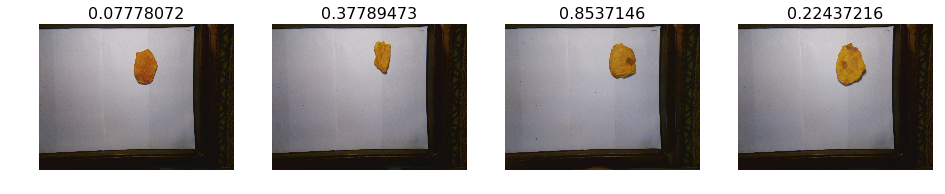

In [29]:
# 1. A few correct labels at random
plot_val_with_title(rand_by_correct(True), "Correctly classified")

In [30]:
# 2. A few incorrect labels at random
plot_val_with_title(rand_by_correct(False), "Incorrectly classified")

ValueError: a must be non-empty

In [32]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    return idxs[np.argsort(mult * probs[idxs])[:4]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

Most correct cats


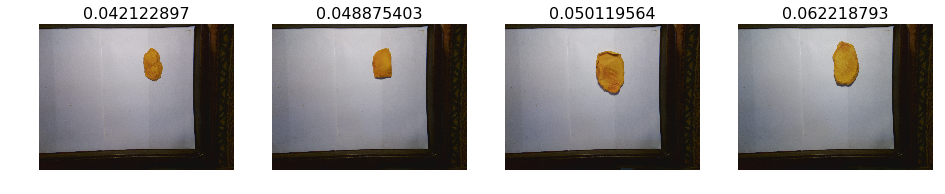

In [33]:
plot_val_with_title(most_by_correct(0, True), "Most correct Qual1")

Most correct Qual2


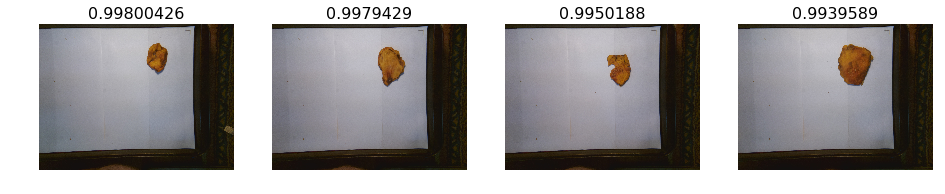

In [34]:
plot_val_with_title(most_by_correct(1, True), "Most correct Qual2")

In [36]:
plot_val_with_title(most_by_correct(0, False), "Most incorrect qual1")

Most incorrect qual1
Not Found.


In [37]:
plot_val_with_title(most_by_correct(1, False), "Most incorrect qual2")

Most incorrect qual2
Not Found.


Most uncertain predictions


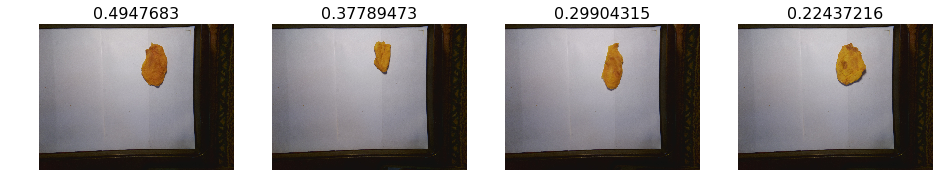

In [39]:
most_uncertain = np.argsort(np.abs(probs -0.5))[:4]
plot_val_with_title(most_uncertain, "Most uncertain predictions")

playing below

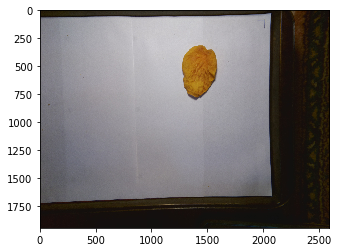

In [46]:
img = plt.imread(f'{PATH}valid/qual1/{files[0]}')
plt.imshow(img);

In [6]:
from PIL import Image

There's a lot of non-mango stuff around the photos. By eyeballing the images, we want to remove about

250px from the top
1000px from the left
550px from the right
700px from the bottom

img.shape is 
(1944, 2592, 3)

So we want to start at pixel (x=1000, y=250) and end at x = (2592-550), y = 1944-700), or (x=2042, y=1244)

In [7]:
# img_test = Image.open(f'{PATH}valid/qual1/mango_2017-09-13 15:44:37.769756.jpg')
img_test = Image.open(f'{PATH}valid/qual1/{files[1]}')
area = (1000, 180, 2024, 1204)  
cropped_img = img_test.crop(area)  # The box is a 4-tuple defining the left, upper, right, and lower pixel
#cropped_img.show()
cropped_img.size

NameError: name 'files' is not defined

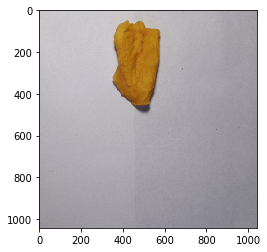

In [13]:
plt.imshow(cropped_img)

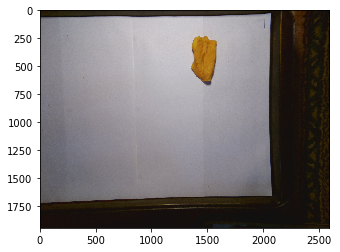

In [72]:
plt.imshow(img_test)

In [28]:
class FixedCrop(CoordTransform):
    """ A class that represents a Fixed Crop transformation. # adapted from RandomCrop
    This transforms (optionally) transforms x,y at with the same parameters.
    Arguments
    ---------
        targ: int
            target size of the crop.
        tfm_y: TfmType
            type of y transformation.
    """
    def __init__(self, targ_sz, tfm_y=TfmType.NO, sz_y=None):
        super().__init__(tfm_y)
        self.targ_sz,self.sz_y = targ_sz,sz_y

#    def set_state(self):
#        self.store.rand_r = random.uniform(0, 1)
#        self.store.rand_c = random.uniform(0, 1)

    def do_transform(self, x, is_y):
        # r,c,*_ = x.shape
        # sz = self.sz_y if is_y else self.targ_sz
        # start_r = np.floor(self.store.rand_r*(r-sz)).astype(int)
        # start_c = np.floor(self.store.rand_c*(c-sz)).astype(int)
        sz = self.sz_y if is_y else self.targ_sz
        start_r = 0
        start_c = 0
        return crop(x, start_r, start_c, sz)



In [29]:
class CropType(IntEnum):
    """ Type of image cropping. """
    RANDOM = 1
    CENTER = 2
    NO = 3
    GOOGLENET = 4
    FIXED = 5
    
crop_fn_lu = {CropType.RANDOM: RandomCrop, CropType.CENTER: CenterCrop, CropType.NO: NoCrop, CropType.GOOGLENET: GoogleNetResize, CropType.FIXED: FixedCrop}

In [66]:
# area = (1000, 180, 2024, 1204)

tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, crop_type=CropType.FIXED, max_zoom=1.1)
# tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [67]:
def  get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

Take a look at some of the data augmentation

In [68]:
ims = np.stack([get_augs() for i in range(6)])

NameError: name 'r' is not defined

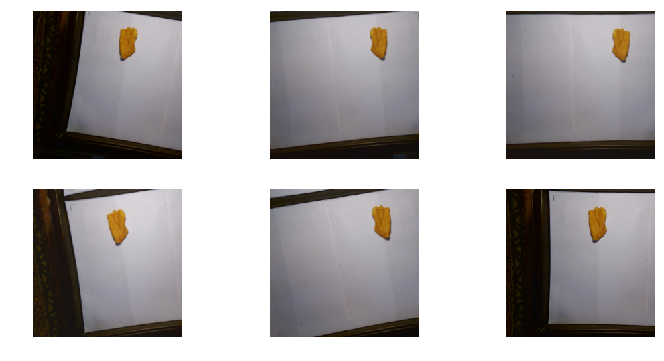

In [60]:
plots(ims, rows=2)

In [ ]:
arch = resnet34
data = ImageClassifierData.from_paths(PATH, tfms=tfms)
learn = ConvLearner.pretrained(arch, data, precompute=True)
learn.fit(0.01, 1)